In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import statistics
import math
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde # for visualization
from scipy.signal import find_peaks
import mplleaflet

In [2]:
eventlog = pd.read_csv("merged_log.csv")
eventlog['Zeitpunkt'] = pd.to_datetime(eventlog['Zeitpunkt'])
#eventlog
prozess_model="Sample Data Process Mining SWM LSA/prozess modell (linienverlauf).csv"
prozess_model = pd.read_csv(prozess_model,sep=";", encoding='latin-1')

In [3]:
eventlog

,caseID,BTN,fahrzeug_nummer,Funkadresse,Odometer,Zeitpunkt,BTN_sequence,Anzahl_der_Telegramme,LAT,LON,LAT_SOLL,LON_SOLL,Linie,Route,LSANR
0,54_17_146_200317_40879020,5840,9165,833,45677,2020-03-17 08:53:48,5840__5841__5842_,3,"48,10984167","11,58868167","48,109819","11,588789",54,17,146
1,54_17_146_200317_40879020,5841,9165,833,45767,2020-03-17 08:53:58,5840__5841__5842_,3,"48,11000333","11,587605","48,109972","11,587744",54,17,146
2,54_17_146_200317_40879020,5842,9165,833,45910,2020-03-17 08:54:15,5840__5841__5842_,3,"48,11053167","11,58568667","48,110481","11,58587",54,17,146
3,54_17_1142_200317_40879020,45680,9165,833,46014,2020-03-17 08:54:27,45680__45681__45682_,3,"48,11089167","11,58437667","48,110845","11,58455",54,17,1142
4,54_17_1142_200317_40879020,45681,9165,833,46151,2020-03-17 08:54:41,45680__45681__45682_,3,"48,11135","11,58279167","48,111312","11,582909",54,17,1142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70306,54_1_159_200317_40788477,6382,5785,805,65294,2020-03-17 18:46:05,6377__6378__6381__6382_,4,"48,11222833","11,50231333","48,11221","11,50248",54,1,159
70307,54_1_417_200317_40788477,16681,5785,805,65326,2020-03-17 18:46:11,16681__16682__16689__16690_,4,"48,11223167","11,50177833","48,112196","11,501868",54,1,417
70308,54_1_417_200317_40788477,16682,5785,805,65356,2020-03-17 18:46:33,16681__16682__16689__16690_,4,"48,11222167","11,50138","48,112194","11,501531",54,1,417
70309,54_1_417_200317_40788477,16689,5785,805,65624,2020-03-17 18:46:58,16681__16682__16689__16690_,4,"48,11224","11,49778667","48,112234","11,498008",54,1,417


In [3]:
def gaussian_kernel_function(t):
    K = np.exp(-t*t/2) / math.sqrt(2*math.pi)
    return K

def probability_density_estimator(t, time_intervals):
    # bandwidth, silvermans rule of thumb
    h = np.std(time_intervals)*(4/3/len(time_intervals))**(1/5)
    if h == 0.0:
        h = 1.0
    
    add = 0.0
    for n in range(len(time_intervals)):
        k = gaussian_kernel_function((t - time_intervals[n]) / h)
        add += k
    f = add / (len(time_intervals) * h)
    
    return f   

In [4]:
def get_time_intervals_la(eventlog):

    time_intervals = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))

    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        if BTN_sequence in time_intervals:  
            for n in range(len(sublist)-1):
                time_interval =  (sublist["Zeitpunkt"][n+1] - sublist["Zeitpunkt"][0]).total_seconds()
                time_intervals[BTN_sequence][n].append(time_interval)
        else:
            for n in range(len(sublist)-1):
                time_interval =  (sublist["Zeitpunkt"][n+1] - sublist["Zeitpunkt"][0]).total_seconds()
                time_intervals.setdefault(BTN_sequence, {})
                time_intervals[BTN_sequence].setdefault(n, [0])[0] = time_interval
    return time_intervals

#full cartesian
def get_time_intervals_fc(eventlog):

    time_intervals = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))

    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        if BTN_sequence in time_intervals: 
            number = 0
            for n in range(len(sublist)-1):
                time_bigger = sublist["Zeitpunkt"][n+1]
                for m in range(n+1):
                    time_smaller = sublist["Zeitpunkt"][m]
                    time_interval = (time_bigger - time_smaller).total_seconds()
                    time_intervals[BTN_sequence][number].append(time_interval)
                    number += 1
            
        else:
            number = 0
            for n in range(len(sublist)-1):
                time_bigger = sublist["Zeitpunkt"][n+1]
                for m in range(n+1):
                    time_smaller = sublist["Zeitpunkt"][m]
                    time_interval = (time_bigger - time_smaller).total_seconds()
                    time_intervals.setdefault(BTN_sequence, {})
                    time_intervals[BTN_sequence].setdefault(number, [0])[0] = time_interval
                    number += 1
                
    return time_intervals

In [5]:
def test_fitness_la(eventlog, time_intervals):

    fitness_score = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))
    
    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        conf_scores = []

        if BTN_sequence in time_intervals:  
            for n in range(len(sublist)-1):
                t =  (sublist["Zeitpunkt"][n+1] - sublist["Zeitpunkt"][0]).total_seconds()
                time_interval = time_intervals[BTN_sequence][n]
                estimate = probability_density_estimator(t, time_interval) # change here
                conf_scores.append(estimate)
            result = np.mean(conf_scores)
        else:
            result = 0

        fitness_score[caseID] = result
        #print(result)
        
    return fitness_score


def test_fitness_fc(eventlog, time_intervals):

    fitness_score = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))
    
    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        conf_scores = []

        if BTN_sequence in time_intervals: 
            number = 0
            for n in range(len(sublist)-1):
                time_bigger = sublist["Zeitpunkt"][n+1]
                for m in range(n+1):
                    time_smaller = sublist["Zeitpunkt"][m]
                    t = (time_bigger - time_smaller).total_seconds()
                    time_interval = time_intervals[BTN_sequence][number]                 
                    estimate = probability_density_estimator(t, time_interval) #change here
                    number += 1
                    conf_scores.append(estimate)
            result = np.mean(conf_scores)
        else:
            result = 0

        fitness_score[caseID] = result
        #print(result)

    return fitness_score

In [6]:
time_intervals_LA = get_time_intervals_la(eventlog)
time_intervals_FC = get_time_intervals_fc(eventlog)

In [7]:
fitness_scores_LA = test_fitness_la(eventlog, time_intervals_LA)
fitness_scores_FC = test_fitness_fc(eventlog, time_intervals_FC)

In [8]:
caseID_list = eventlog["caseID"].tolist()
caseID_list = list(dict.fromkeys(caseID_list))
len(caseID_list)

20721

# Anomaly Detection

### find anomalies LA

In [271]:
anomalies_la = []

BTN_sequence_list = eventlog["BTN_sequence"].tolist()
BTN_sequence_list = list(dict.fromkeys(BTN_sequence_list))

for sequence in BTN_sequence_list:
    sublog = eventlog.loc[eventlog["BTN_sequence"]==sequence]
    
    time_intervals_la = get_time_intervals_la(sublog)
    fitness_scores_la = test_fitness_la(sublog, time_intervals_la)
    
    values_la = list(fitness_scores_la.values())
    density = gaussian_kde(values_la)
    xs = np.linspace(0,1,2000)
    density.set_bandwidth(bw_method=density.factor*0.33)
    density._compute_covariance()
    ys = density(xs)

    # find peaks in distribution
    peaks, _ = find_peaks(ys, height=0)
    try:
        max_peak = max(xs[peaks])
    except:
        print(sequence)
    selected_peaks = []
    for peak in peaks:
        if xs[peak] > 0.5*max_peak:
            selected_peaks.append(peak)

    # get bandwidth and set boundary        
    values = np.array(values_la)
    f = density.covariance_factor()
    bw = f * values.std()
    try:
        smallest_peak = min(xs[selected_peaks])
    except:
        print(sequence)
    boundary = smallest_peak - bw*3
    
    new_anomalies = [item for item in fitness_scores_la if fitness_scores_la[item] < boundary]
    anomalies_la.extend(new_anomalies)

In [116]:
len(anomalies_la)/len(caseID_list)

0.19352347859659283

In [272]:
final_anomalies_la = anomalies_la

for anomaly in final_anomalies_la:
    case = eventlog.loc[eventlog["caseID"]==anomaly]
    case.reset_index(drop=True, inplace=True)
    BTN_sequence = case["BTN_sequence"][0]
    
    # LA
    if BTN_sequence in time_intervals_LA: 
        n = len(case)

        t = (case["Zeitpunkt"][n-1] - case["Zeitpunkt"][0]).total_seconds()
        time_interval = time_intervals_LA[BTN_sequence][n-2]                 
        if t < np.mean(time_interval):
            final_anomalies_la.remove(anomaly)

In [118]:
len(final_anomalies_la)/len(caseID_list)

0.1499927609671348

### find anomalies FC

In [273]:
anomalies_fc = []

BTN_sequence_list = eventlog["BTN_sequence"].tolist()
BTN_sequence_list = list(dict.fromkeys(BTN_sequence_list))

for sequence in BTN_sequence_list:
    sublog = eventlog.loc[eventlog["BTN_sequence"]==sequence]
    
    time_intervals_fc = get_time_intervals_fc(sublog)
    fitness_scores_fc = test_fitness_fc(sublog, time_intervals_fc)
    
    values_fc = list(fitness_scores_fc.values())
    density = gaussian_kde(values_fc)
    xs = np.linspace(0,1,2000)
    density.set_bandwidth(bw_method=density.factor*0.33)
    density._compute_covariance()
    ys = density(xs)

    # find peaks in distribution
    peaks, _ = find_peaks(ys, height=0)
    try:
        max_peak = max(xs[peaks])
    except:
        print(sequence)
    selected_peaks = []
    for peak in peaks:
        if xs[peak] > 0.5*max_peak:
            selected_peaks.append(peak)

    # get bandwidth and set boundary        
    values = np.array(values_fc)
    f = density.covariance_factor()
    bw = f * values.std()
    try:
        smallest_peak = min(xs[selected_peaks])
    except:
        print(sequence)
    boundary = smallest_peak - bw*3
    
    new_anomalies = [item for item in fitness_scores_fc if fitness_scores_fc[item] < boundary]
    anomalies_fc.extend(new_anomalies)

In [120]:
len(anomalies_fc)/len(caseID_list)

0.13372906712996477

In [274]:
final_anomalies_fc = anomalies_fc

for anomaly in final_anomalies_fc:
    case = eventlog.loc[eventlog["caseID"]==anomaly]
    case.reset_index(drop=True, inplace=True)
    BTN_sequence = case["BTN_sequence"][0]
    
    # FC
    if BTN_sequence in time_intervals_FC: 
        n=len(case)

        t = (case["Zeitpunkt"][n-1] - case["Zeitpunkt"][0]).total_seconds()
        number = (n-1)*(n-2)/2
        time_interval = time_intervals_FC[BTN_sequence][number] 
        
        if t < np.mean(time_interval):
            final_anomalies_fc.remove(anomaly)

In [122]:
len(final_anomalies_fc)/len(caseID_list)

0.10955069736016601

# micro clustering

## full Cartesian

### separate with LAS number

In [123]:
cases_separated_by_LSA = {}

for case in caseID_list:
    LSA = re.findall('[0-9]+', case)[2]
    
    if LSA in cases_separated_by_LSA:
        cases_separated_by_LSA[LSA] += [case]
    else:
        cases_separated_by_LSA[LSA] = [case]

In [124]:
anomalies_fc_separated = {}

for anomaly in final_anomalies_fc:
    LSA = re.findall('[0-9]+', anomaly)[2]
    
    if LSA in anomalies_fc_separated:
        anomalies_fc_separated[LSA] += [anomaly]
    else:
        anomalies_fc_separated[LSA] = [anomaly]

In [125]:
LSA_percentage_fc = {}

for LSA in anomalies_fc_separated:
    if LSA in cases_separated_by_LSA:
        LSA_percentage_fc[LSA] = len(anomalies_fc_separated[LSA]) / len(cases_separated_by_LSA[LSA])

LSA_percentage_fc = sorted(LSA_percentage_fc.items(), key=lambda item: item[1], reverse=True)

In [126]:
LSA_percentage_fc

[('72', 0.358974358974359),
 ('612', 0.3211009174311927),
 ('193', 0.2912621359223301),
 ('490', 0.2804232804232804),
 ('232', 0.26014319809069214),
 ('133', 0.23423423423423423),
 ('63', 0.22865853658536586),
 ('1069', 0.22167487684729065),
 ('1142', 0.22105263157894736),
 ('47', 0.2158273381294964),
 ('1103', 0.21428571428571427),
 ('194', 0.20588235294117646),
 ('702', 0.20398009950248755),
 ('424', 0.2),
 ('440', 0.19196428571428573),
 ('320', 0.1902439024390244),
 ('6', 0.1891891891891892),
 ('417', 0.17535545023696683),
 ('155', 0.16666666666666666),
 ('879', 0.16585365853658537),
 ('59', 0.1657754010695187),
 ('10', 0.1650943396226415),
 ('146', 0.1601423487544484),
 ('680', 0.15644171779141106),
 ('1133', 0.15263157894736842),
 ('290', 0.15178571428571427),
 ('76', 0.14457831325301204),
 ('1174', 0.14285714285714285),
 ('707', 0.14022140221402213),
 ('73', 0.13333333333333333),
 ('209', 0.1318267419962335),
 ('192', 0.13157894736842105),
 ('33', 0.12698412698412698),
 ('39', 0.

### separate with BTN sequence

In [179]:
cases_separated_by_sequence = {}

for caseID in caseID_list:
    
    case = eventlog.loc[eventlog["caseID"]==caseID]
    case.reset_index(drop=True, inplace=True)
    BTN_sequence = case["BTN_sequence"][0]

    if BTN_sequence in cases_separated_by_sequence:
        cases_separated_by_sequence[BTN_sequence] += [caseID]
    else:
        cases_separated_by_sequence[BTN_sequence] = [caseID]

In [275]:
anomalies_fc_separated_by_sequence = {}

for anomaly in final_anomalies_fc:
    
    case = eventlog.loc[eventlog["caseID"]==anomaly]
    case.reset_index(drop=True, inplace=True)
    BTN_sequence = case["BTN_sequence"][0]
    
    if BTN_sequence in anomalies_fc_separated_by_sequence:
        anomalies_fc_separated_by_sequence[BTN_sequence] += [anomaly]
    else:
        anomalies_fc_separated_by_sequence[BTN_sequence] = [anomaly]

In [276]:
sequence_percentage_fc = {}

for BTN_sequence in anomalies_fc_separated_by_sequence:
    if BTN_sequence in cases_separated_by_sequence:
        sequence_percentage_fc[BTN_sequence] = len(anomalies_fc_separated_by_sequence[BTN_sequence]) / len(cases_separated_by_sequence[BTN_sequence])
        
sequence_percentage_fc = sorted(sequence_percentage_fc.items(), key=lambda item: item[1], reverse=True)

In [182]:
sequence_percentage_fc

[('1880__1881__1882_', 0.35135135135135137),
 ('2884__2885__2886_', 0.3333333333333333),
 ('24485__24486_', 0.3235294117647059),
 ('6200__6201_', 0.308411214953271),
 ('2444__2445__2446_', 0.2625),
 ('772__773__774__775_', 0.25),
 ('19052__19053_', 0.25),
 ('46964__46965__46966__46973__46974_', 0.25),
 ('2529__2530_', 0.24858757062146894),
 ('44144__44145_', 0.23648648648648649),
 ('1320__1321__1322_', 0.23636363636363636),
 ('7726__7725__7724_', 0.23076923076923078),
 ('844__845__846_', 0.22784810126582278),
 ('2404__2405__2406__2414_', 0.21794871794871795),
 ('7766__7765__7764_', 0.21568627450980393),
 ('11305__11292__11293__11306__11294_', 0.21428571428571427),
 ('45320__45321__45322_', 0.20909090909090908),
 ('249__250_', 0.20270270270270271),
 ('19601__19602_', 0.2018348623853211),
 ('6776__6777__6778__6779_', 0.2),
 ('408__409_', 0.1941747572815534),
 ('11280__11281__11282_', 0.192090395480226),
 ('3316__3317__3318_', 0.19148936170212766),
 ('44156__44157__44158_', 0.189655172413

### separate with bus

In [131]:
def get_bus_number(caseID):
    for bus_number in cases_separated_by_bus:
        if caseID in cases_separated_by_bus[bus_number]:
             return bus_number

In [132]:
cases_separated_by_bus = {}

for caseID in caseID_list:
    
    case = eventlog.loc[eventlog["caseID"]==caseID]
    case.reset_index(drop=True, inplace=True)
    bus_number = case["fahrzeug_nummer"][0]

    if bus_number in cases_separated_by_bus:
        cases_separated_by_bus[bus_number] += [caseID]
    else:
        cases_separated_by_bus[bus_number] = [caseID]

In [133]:
anomalies_fc_separated_by_bus = {}

for anomaly in final_anomalies_fc:
    
    bus_number = get_bus_number(anomaly)
    
    if bus_number in anomalies_fc_separated_by_bus:
        anomalies_fc_separated_by_bus[bus_number] += [anomaly]
    else:
        anomalies_fc_separated_by_bus[bus_number] = [anomaly]

In [134]:
bus_percentage_fc = {}

for bus_number in anomalies_fc_separated_by_bus:
    if bus_number in cases_separated_by_bus:
        bus_percentage_fc[bus_number] = len(anomalies_fc_separated_by_bus[bus_number]) / len(cases_separated_by_bus[bus_number])
        
bus_percentage_fc = sorted(bus_percentage_fc.items(), key=lambda item: item[1], reverse=True)

In [135]:
bus_percentage_fc

[(9165, 0.21052631578947367),
 (5786, 0.1840607210626186),
 (9174, 0.1794871794871795),
 (4337, 0.175),
 (5366, 0.16477272727272727),
 (5643, 0.1540880503144654),
 (4927, 0.15),
 (9348, 0.1490566037735849),
 (5785, 0.1464968152866242),
 (9279, 0.13559322033898305),
 (9350, 0.13261648745519714),
 (5673, 0.1323943661971831),
 (5748, 0.12830188679245283),
 (9045, 0.12704174228675136),
 (9552, 0.12618296529968454),
 (5426, 0.12454212454212454),
 (4949, 0.12401055408970976),
 (5409, 0.12208258527827648),
 (5281, 0.12018140589569161),
 (9380, 0.1180952380952381),
 (5647, 0.11594202898550725),
 (5431, 0.1154970760233918),
 (4981, 0.11475409836065574),
 (5322, 0.1130690161527166),
 (9237, 0.11235955056179775),
 (5663, 0.11185682326621924),
 (5352, 0.1111111111111111),
 (5668, 0.10991957104557641),
 (9517, 0.10898379970544919),
 (5637, 0.1085383502170767),
 (5644, 0.10655737704918032),
 (4942, 0.10526315789473684),
 (5537, 0.1038135593220339),
 (9030, 0.10344827586206896),
 (5522, 0.10289855072

### for each line and route

In [136]:
line_and_route = []

for caseID in caseID_list:
    line = re.findall('[0-9]+', caseID)[0]
    route = re.findall('[0-9]+', caseID)[1]
    line_and_route.append((line, route))
    
line_and_route = list(dict.fromkeys(line_and_route))
#line_and_route

In [137]:
route_percentage_fc = {}

for (line, route) in line_and_route:

    line_route = str(line) + "_" + str(route)
    line = int(line)
    route = int(route)    
    
    bus_route_log = eventlog.loc[(eventlog["Linie"]==line) & (eventlog["Route"]==route)]

    cases_of_route = bus_route_log["caseID"].tolist()
    cases_of_route = list(dict.fromkeys(cases_of_route))
    
    anomalies_of_route = []
    
    for case in cases_of_route:
        if case in final_anomalies_fc:
            anomalies_of_route.append(case)

    route_percentage_fc[line_route] = len(anomalies_of_route) / len(cases_of_route) 
    
route_percentage_fc = sorted(route_percentage_fc.items(), key=lambda item: item[1], reverse=True)

In [138]:
route_percentage_fc

[('68_31', 0.16666666666666666),
 ('58_44', 0.15384615384615385),
 ('58_46', 0.15384615384615385),
 ('58_14', 0.14358108108108109),
 ('58_6', 0.1318181818181818),
 ('54_24', 0.12962962962962962),
 ('54_22', 0.122334455667789),
 ('58_2', 0.12222222222222222),
 ('154_1', 0.12046672973825291),
 ('68_1', 0.12002652519893899),
 ('54_14', 0.12),
 ('54_18', 0.11986301369863013),
 ('68_37', 0.11538461538461539),
 ('54_19', 0.1111111111111111),
 ('54_1', 0.10629129560471129),
 ('154_2', 0.10262008733624454),
 ('58_40', 0.10256410256410256),
 ('68_43', 0.10144927536231885),
 ('58_36', 0.1),
 ('58_48', 0.09523809523809523),
 ('68_39', 0.09090909090909091),
 ('44_9', 0.09090909090909091),
 ('58_32', 0.08860759493670886),
 ('58_42', 0.08695652173913043),
 ('68_9', 0.07936507936507936),
 ('54_36', 0.0784313725490196),
 ('54_9', 0.07692307692307693),
 ('54_17', 0.07630522088353414),
 ('54_11', 0.06993006993006994),
 ('54_3', 0.06896551724137931),
 ('54_5', 0.06666666666666667),
 ('54_20', 0.064516129

## Left Alignment

### separate with LAS number

In [139]:
anomalies_la_separated = {}

for anomaly in final_anomalies_la:
    LSA = re.findall('[0-9]+', anomaly)[2]
    
    if LSA in anomalies_la_separated:
        anomalies_la_separated[LSA] += [anomaly]
    else:
        anomalies_la_separated[LSA] = [anomaly]

In [140]:
LSA_percentage_la = {}

for LSA in anomalies_la_separated:
    if LSA in cases_separated_by_LSA:
        LSA_percentage_la[LSA] = len(anomalies_la_separated[LSA]) / len(cases_separated_by_LSA[LSA])

LSA_percentage_la = sorted(LSA_percentage_la.items(), key=lambda item: item[1], reverse=True)

In [141]:
LSA_percentage_la

[('72', 0.358974358974359),
 ('612', 0.3211009174311927),
 ('169', 0.2857142857142857),
 ('490', 0.2804232804232804),
 ('702', 0.27860696517412936),
 ('93', 0.2774869109947644),
 ('1103', 0.2701863354037267),
 ('87', 0.26046511627906976),
 ('377', 0.25),
 ('476', 0.25),
 ('111', 0.25),
 ('15', 0.24924012158054712),
 ('1133', 0.23157894736842105),
 ('162', 0.23076923076923078),
 ('63', 0.2225609756097561),
 ('680', 0.22085889570552147),
 ('318', 0.21717171717171718),
 ('59', 0.21390374331550802),
 ('232', 0.2100238663484487),
 ('575', 0.2098360655737705),
 ('320', 0.2097560975609756),
 ('199', 0.2088888888888889),
 ('193', 0.2087378640776699),
 ('1142', 0.20701754385964913),
 ('194', 0.20588235294117646),
 ('707', 0.1992619926199262),
 ('1101', 0.1987179487179487),
 ('20', 0.1984126984126984),
 ('440', 0.19642857142857142),
 ('82', 0.19572953736654805),
 ('952', 0.19534883720930232),
 ('33', 0.19047619047619047),
 ('6', 0.1891891891891892),
 ('113', 0.183206106870229),
 ('211', 0.181481

### separate with BTN sequence

In [277]:
anomalies_la_separated_by_sequence = {}

for anomaly in final_anomalies_la:
    
    case = eventlog.loc[eventlog["caseID"]==anomaly]
    case.reset_index(drop=True, inplace=True)
    BTN_sequence = case["BTN_sequence"][0]
    
    if BTN_sequence in anomalies_la_separated_by_sequence:
        anomalies_la_separated_by_sequence[BTN_sequence] += [anomaly]
    else:
        anomalies_la_separated_by_sequence[BTN_sequence] = [anomaly]

In [278]:
sequence_percentage_la = {}

for BTN_sequence in anomalies_la_separated_by_sequence:
    if BTN_sequence in cases_separated_by_sequence:
        sequence_percentage_la[BTN_sequence] = len(anomalies_la_separated_by_sequence[BTN_sequence]) / len(cases_separated_by_sequence[BTN_sequence])
        
sequence_percentage_la = sorted(sequence_percentage_la.items(), key=lambda item: item[1], reverse=True)

In [302]:
sequence_percentage_la

[('6768__6769__6770__6771_', 0.47572815533980584),
 ('804__805__806_', 0.42857142857142855),
 ('3320__3321__3322__3323_', 0.4),
 ('608__609__610_', 0.3618421052631579),
 ('3720__3721__3722_', 0.336283185840708),
 ('2884__2885__2886_', 0.3333333333333333),
 ('24485__24486_', 0.3235294117647059),
 ('23444__23445__23446_', 0.3137254901960784),
 ('6200__6201_', 0.308411214953271),
 ('45680__45681__45682_', 0.2937062937062937),
 ('5426__5429__5430_', 0.2746478873239437),
 ('44156__44157__44158_', 0.27011494252873564),
 ('44041__44042__44057__44058_', 0.2695035460992908),
 ('7722__7721__7720_', 0.2647058823529412),
 ('3004__3005__3006_', 0.2631578947368421),
 ('23025__23026__23029__23030_', 0.2589928057553957),
 ('2680__2681__2682__2683_', 0.25757575757575757),
 ('2761__2762__2777__2778_', 0.25396825396825395),
 ('12800__12801__12802_', 0.2524271844660194),
 ('15096__15097__15098_', 0.25),
 ('19064__19065__19066_', 0.25),
 ('4445__4448__4449_', 0.25),
 ('4440__4441__4442_', 0.25),
 ('34012__

### separated with bus

In [145]:
anomalies_la_separated_by_bus = {}

for anomaly in final_anomalies_la:
    
    bus_number = get_bus_number(anomaly)
    
    if bus_number in anomalies_la_separated_by_bus:
        anomalies_la_separated_by_bus[bus_number] += [anomaly]
    else:
        anomalies_la_separated_by_bus[bus_number] = [anomaly]

In [146]:
bus_percentage_la = {}

for bus_number in anomalies_la_separated_by_bus:
    if bus_number in cases_separated_by_bus:
        bus_percentage_la[bus_number] = len(anomalies_la_separated_by_bus[bus_number]) / len(cases_separated_by_bus[bus_number])
        
bus_percentage_la = sorted(bus_percentage_la.items(), key=lambda item: item[1], reverse=True)

In [147]:
bus_percentage_la

[(9165, 0.23684210526315788),
 (4337, 0.225),
 (5786, 0.222011385199241),
 (5366, 0.2159090909090909),
 (4942, 0.21052631578947367),
 (4981, 0.20218579234972678),
 (4228, 0.2),
 (9552, 0.1892744479495268),
 (5352, 0.18518518518518517),
 (5643, 0.18238993710691823),
 (4936, 0.18181818181818182),
 (5748, 0.1811320754716981),
 (9176, 0.1794871794871795),
 (9174, 0.1794871794871795),
 (5785, 0.1751592356687898),
 (5431, 0.1739766081871345),
 (5647, 0.17391304347826086),
 (9348, 0.17358490566037735),
 (9030, 0.1724137931034483),
 (9045, 0.1724137931034483),
 (5426, 0.17216117216117216),
 (5409, 0.17055655296229802),
 (9293, 0.1694915254237288),
 (5281, 0.16326530612244897),
 (5755, 0.16111111111111112),
 (5644, 0.15846994535519127),
 (4949, 0.158311345646438),
 (5657, 0.15458937198067632),
 (9237, 0.15409309791332262),
 (9279, 0.15254237288135594),
 (9350, 0.15053763440860216),
 (5334, 0.15009041591320071),
 (4927, 0.15),
 (4958, 0.1468682505399568),
 (9380, 0.14666666666666667),
 (5537, 0.

### for each line and route

In [148]:
route_percentage_la = {}

for (line, route) in line_and_route:

    line_route = str(line) + "_" + str(route)
    line = int(line)
    route = int(route)
    #route_percentage_la[line_route] = {}
    
    bus_route_log = eventlog.loc[(eventlog["Linie"]==line) & (eventlog["Route"]==route)]
    #bus_route_log.reset_index(drop=True, inplace=True)

    cases_of_route = bus_route_log["caseID"].tolist()
    cases_of_route = list(dict.fromkeys(cases_of_route))
    
    anomalies_of_route = []
    
    for case in cases_of_route:
        if case in final_anomalies_la:
            anomalies_of_route.append(case)

    route_percentage_la[line_route] = len(anomalies_of_route) / len(cases_of_route) 
    
route_percentage_la = sorted(route_percentage_la.items(), key=lambda item: item[1], reverse=True)

In [149]:
route_percentage_la

[('54_19', 0.3333333333333333),
 ('58_44', 0.2564102564102564),
 ('54_3', 0.20689655172413793),
 ('68_37', 0.19230769230769232),
 ('58_14', 0.1891891891891892),
 ('58_6', 0.17662337662337663),
 ('68_1', 0.17506631299734748),
 ('58_42', 0.17391304347826086),
 ('58_40', 0.17094017094017094),
 ('54_11', 0.16783216783216784),
 ('54_1', 0.16460787130135018),
 ('68_43', 0.15942028985507245),
 ('154_2', 0.1543980037429819),
 ('58_46', 0.15384615384615385),
 ('44_9', 0.15151515151515152),
 ('54_18', 0.14726027397260275),
 ('58_36', 0.14285714285714285),
 ('54_22', 0.14113355780022446),
 ('154_1', 0.13970356354462315),
 ('54_36', 0.13725490196078433),
 ('58_2', 0.13333333333333333),
 ('54_17', 0.13253012048192772),
 ('54_24', 0.12962962962962962),
 ('54_20', 0.12903225806451613),
 ('68_9', 0.12244897959183673),
 ('58_32', 0.12025316455696203),
 ('68_31', 0.11904761904761904),
 ('58_48', 0.11904761904761904),
 ('54_5', 0.1111111111111111),
 ('54_9', 0.10256410256410256),
 ('54_26', 0.09859154929

# Visualization

### plot one BTN sequence

In [195]:
check = eventlog.loc[eventlog["caseID"]=="54_22_10_200317_40859261"]
check.reset_index(drop=True, inplace=True)
check

,caseID,BTN,Funkadresse,Odometer,Zeitpunkt,BTN_sequence,Anzahl_der_Telegramme,LAT,LON,LAT_SOLL,LON_SOLL,Linie,Route
0,54_22_10_200317_40859261,408,251,141347,2020-03-17 15:01:50,408__409_,2,"48,15901833","11,58542667","48,159179","11,585479",54,22
1,54_22_10_200317_40859261,409,251,141660,2020-03-17 15:04:38,408__409_,2,"48,16171833","11,58643","48,16177","11,5864",54,22


In [196]:
samplelog = eventlog.loc[eventlog["BTN_sequence"]=="408__409_"]
samplelog.reset_index(drop=True, inplace=True)

In [197]:
samplelog

,caseID,BTN,Funkadresse,Odometer,Zeitpunkt,BTN_sequence,Anzahl_der_Telegramme,LAT,LON,LAT_SOLL,LON_SOLL,Linie,Route
0,54_22_10_200317_40859261,408,251,141347,2020-03-17 15:01:50,408__409_,2,"48,15901833","11,58542667","48,159179","11,585479",54,22
1,54_22_10_200317_40859261,409,251,141660,2020-03-17 15:04:38,408__409_,2,"48,16171833","11,58643","48,16177","11,5864",54,22
2,54_22_10_200317_40859446,408,251,231455,2020-03-17 21:32:58,408__409_,2,"48,15911667","11,58544667","48,159179","11,585479",54,22
3,54_22_10_200317_40859446,409,251,231749,2020-03-17 21:34:06,408__409_,2,"48,16167167","11,58643667","48,16177","11,5864",54,22
4,54_22_10_200317_40859441,408,251,186388,2020-03-17 18:21:51,408__409_,2,"48,15893167","11,58522667","48,159179","11,585479",54,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,54_22_10_200317_40788474,409,805,41562,2020-03-17 17:08:52,408__409_,2,"48,1616","11,58632","48,16177","11,5864",54,22
202,54_22_10_200317_40788479,408,805,85997,2020-03-17 20:19:57,408__409_,2,"48,15936167","11,58551333","48,159179","11,585479",54,22
203,54_22_10_200317_40788479,409,805,86292,2020-03-17 20:20:45,408__409_,2,"48,16195333","11,58645833","48,16177","11,5864",54,22
204,54_24_10_200317_40788459,408,805,19085,2020-03-17 07:24:41,408__409_,2,"48,159215","11,58542","48,159179","11,585479",54,24


In [198]:
sample_cases = samplelog["caseID"].tolist()
sample_cases = list(dict.fromkeys(sample_cases))

In [202]:
x_anomaly = []
y_anomaly = []
x_others = []
y_others = []

for case in sample_cases:
    #if case in test:

    sublist = samplelog.loc[samplelog["caseID"]==case]
    sublist.reset_index(drop=True, inplace=True)

    longitude = sublist["LON"][0]
    latitude = sublist["LAT"][0]

    if isinstance(longitude, str) & isinstance(latitude, str):# & longitude != "0" & latitude != "0":
        longitude = longitude.replace(",", ".")
        latitude = latitude.replace(",", ".")

        if case in anomalies:
            x_anomaly.append(float(longitude))
            y_anomaly.append(float(latitude))
        else:
            x_others.append(float(longitude))
            y_others.append(float(latitude))

In [204]:
line_plot_fig, line_plot_ax = plt.subplots()
line_plot_ax.plot(x_anomaly, y_anomaly, 'r.')
line_plot_ax.plot(x_others, y_others, 'g.')
mplleaflet.display(fig=line_plot_fig)

### plot one bus route

In [126]:
#events_prozess_model

,REIHENFOLGE,LINIE,ROUTE,ART,BEZEICHNUNG,LSANR,BAKENTELEGRAMMNUMMER,BAKENR,TABELLENNUMMER_BAKE,FUNKKANAL,SIGNAL,ABSTAND_HP,ABSTAND_GESAMT,ID_MP,ID_MP_KETTE,LAT_SOLL,LON_SOLL,ODV_VEREINFACHT
0,1,43,1,HP,"OBF 2, Ostbahnhof",NaN,0,0,0,0,NaN,0,0,0,0,NaN,NaN,NaN
1,2,43,1,MP,41,15.0,605,151,1,2,FV04,0,100,2631,0,"48,127603","11,603204",1.0
2,3,43,1,MP,42,15.0,612,153,0,2,FV04,0,350,2632,0,"48,126223","11,600759",1.0
3,4,43,1,MP,61,132.0,5316,1329,0,2,FV05,0,456,2634,0,"48,125401","11,599483",1.0
4,5,43,1,Signal,Signal: FV04,15.0,0,0,0,0,FV04,0,470,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21009,7,154,904,HP,"UNI 74, Universität",NaN,0,0,0,0,NaN,1015,1015,0,0,NaN,NaN,NaN
21010,1,154,905,HP,"ARP 5, Arabellapark",NaN,0,0,0,0,NaN,0,0,0,0,NaN,NaN,NaN
21011,2,154,905,HP,"ARN 1, Arabellapark Nord",NaN,0,0,0,0,NaN,361,361,0,0,NaN,NaN,NaN
21012,1,154,906,HP,"UNI 72, Universität",NaN,0,0,0,0,NaN,0,0,0,0,NaN,NaN,NaN


In [208]:
linie = 54
route = 17

bus_route_log = events_prozess_model.loc[(events_prozess_model["LINIE"]==linie) & (events_prozess_model["ROUTE"]==route)]
bus_route_log.reset_index(drop=True, inplace=True)
#bus_route_log

event_sublog = eventlog.loc[(eventlog["Linie"]==linie) & (eventlog["Route"]==route)]
event_sublog.reset_index(drop=True, inplace=True)

In [209]:
sample_cases = event_sublog["caseID"].tolist()
sample_cases = list(dict.fromkeys(sample_cases))

x_anomaly = []
y_anomaly = []
x_others = []
y_others = []

for case in sample_cases:
    #if case in test:

    sublist = event_sublog.loc[event_sublog["caseID"]==case]
    sublist.reset_index(drop=True, inplace=True)

    longitude = sublist["LON"][0]
    latitude = sublist["LAT"][0]

    if isinstance(longitude, str) & isinstance(latitude, str):# & longitude != "0" & latitude != "0":
        longitude = longitude.replace(",", ".")
        latitude = latitude.replace(",", ".")

        if case in anomalies:
            x_anomaly.append(float(longitude))
            y_anomaly.append(float(latitude))
        else:
            x_others.append(float(longitude))
            y_others.append(float(latitude))

In [210]:
x_route = bus_route_log["LON_SOLL"].tolist()
y_route = bus_route_log["LAT_SOLL"].tolist()
x_route = [item for item in x_route if type(item) == str]
y_route = [item for item in y_route if type(item) == str]
x_route_final = []
y_route_final = []

for item in x_route:
    item = item.replace(",",".")
    x_route_final.append(float(item))

for item in y_route:
    item = item.replace(",",".")
    y_route_final.append(float(item))

NameError: name 'x_route_final' is not defined

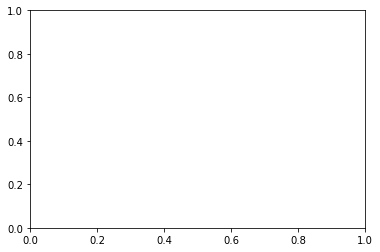

In [266]:
# plot
line_plot_fig, line_plot_ax = plt.subplots()
line_plot_ax.plot(x_route_final, y_route_final, 'b', linewidth=2)

line_plot_ax.plot(x_anomaly, y_anomaly, 'r.')
line_plot_ax.plot(x_others, y_others, 'g.')

#circle1 = plt.Circle((x_route_final[7], y_route_final[7]), 0.0005, color='r', fill=False)
line_plot_ax.add_artist(circle1)

In [ ]:
mplleaflet.display(fig=line_plot_fig)

### all BTN sequences

In [161]:
edited_model = pd.read_csv("edited_model.csv")

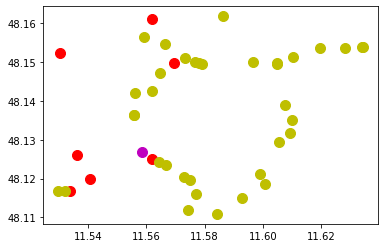

In [279]:
line_plot_fig, line_plot_ax = plt.subplots()

for (BTN_sequence, perc) in sequence_percentage_fc:
    model = edited_model.loc[edited_model["BTN_sequence"]==BTN_sequence]
    model.reset_index(drop=True, inplace=True)
    
    lon = model["LON_SOLL"][1]
    lat = model["LAT_SOLL"][1]
    lon = lon.replace(",", ".")
    lat = lat.replace(",", ".")
    lon = float(lon)
    lat = float(lat)
    
    if perc >= 0.35:
        line_plot_ax.plot(lon, lat, 'm.', markersize = 20)
    elif perc >= 0.25:
        line_plot_ax.plot(lon, lat, 'r.', markersize = 20)
    elif perc >= 0.15:
        line_plot_ax.plot(lon, lat, 'y.', markersize = 20)
    #else:
        #line_plot_ax.plot(lon, lat, 'g.', markersize = 12)

In [196]:
mplleaflet.display(fig=line_plot_fig)

In [1]:
line_plot_fig, line_plot_ax = plt.subplots()

for (BTN_sequence, perc) in sequence_percentage_la:
    model = edited_model.loc[edited_model["BTN_sequence"]==BTN_sequence]
    model.reset_index(drop=True, inplace=True)
    
    lon = model["LON_SOLL"][1]
    lat = model["LAT_SOLL"][1]
    lon = lon.replace(",", ".")
    lat = lat.replace(",", ".")
    lon = float(lon)
    lat = float(lat)
    
    if perc >= 0.35:
        line_plot_ax.plot(lon, lat, 'm.', markersize = 20)
    elif perc >= 0.25:
        line_plot_ax.plot(lon, lat, 'r.', markersize = 20)
    elif perc >= 0.15:
        line_plot_ax.plot(lon, lat, 'y.', markersize = 20)
    #else:
        #line_plot_ax.plot(lon, lat, 'g.', markersize = 12)

NameError: name 'plt' is not defined

In [ ]:
mplleaflet.display(fig=line_plot_fig)

In [ ]:
mplleaflet.show(fig=line_plot_fig)